In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
def load_log(fname):
    log = np.genfromtxt(fname)
    _, indices = np.unique(log[:,0], return_index=True)
    log = log[sorted(indices)]
    return log

In [4]:
gals_idx = {}
gals_idx['MW7_GSE4_sf02_l5'] = {}
gals_idx['MW7_GSE4_sf03_l5'] = {}
gals_idx['MW7_GSE4_sf04_l5'] = {}

for idx in tqdm(np.arange(400+1)):
    try:
        gals_idx['MW7_GSE4_sf02_l5'][idx] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-softfactor02/output', 
                                                 idx, orient=True, parttype=[0, 4])
    except:
        pass
        
    try:
        gals_idx['MW7_GSE4_sf03_l5'][idx] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64/output', 
                                                 idx, orient=True, parttype=[0, 4])
    except:
        pass
        
    try:
        gals_idx['MW7_GSE4_sf04_l5'][idx] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-softfactor04/output', 
                                                 idx, orient=True, parttype=[0, 4])
    except:
        pass

  1%|          | 5/401 [00:01<01:47,  3.68it/s]/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py:100: RuntimeWarning: invalid value encountered in divide
  AngMom_dir = AngMom/np.linalg.norm(AngMom)
/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py:103: RuntimeWarning: invalid value encountered in divide
  k /= np.linalg.norm(k)
100%|██████████| 401/401 [02:30<00:00,  2.66it/s]


In [6]:
sfr = {}
sfr['MW7_GSE4_sf02_l5'] = load_log(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-softfactor02/output/sfr.txt')
sfr['MW7_GSE4_sf03_l5'] = load_log(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64/output/sfr.txt')
sfr['MW7_GSE4_sf04_l5'] = load_log(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-softfactor04/output/sfr.txt')

(0.0, 13.7392605)

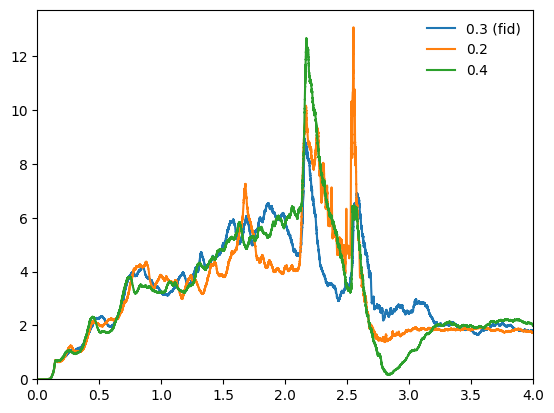

In [19]:
plt.plot(sfr['MW7_GSE4_sf03_l5'][:,0], sfr['MW7_GSE4_sf03_l5'][:,2], label='0.3 (fid)')
plt.plot(sfr['MW7_GSE4_sf02_l5'][:,0], sfr['MW7_GSE4_sf02_l5'][:,2], label='0.2')
plt.plot(sfr['MW7_GSE4_sf04_l5'][:,0], sfr['MW7_GSE4_sf04_l5'][:,2], label='0.4')
plt.legend(frameon=False)
plt.xlim(0, 4)
plt.ylim(0, None)

In [22]:
def get_logFeH_logMgFe(gal, ptype=4):
    GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    part = getattr(gal.sn, 'part'+str(ptype))
    
    FeH = part.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = part.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgH = np.log10(MgH)
    logMgFe = np.log10(MgFe)
    
    return logFeH, logMgH, logMgFe

In [68]:
def in_SN(gal, ptype, Rmin=4, Rmax=16, zmin=0, zmax=3):
    part = getattr(gal.sn, 'part'+str(ptype))
    R = np.linalg.norm(part.rotpos[:,:2], axis=1)
    z = part.rotpos[:,2]
    key_R = np.logical_and(R < Rmax, R > Rmin)
    key = np.logical_and(key_R, np.abs(z) < zmax)
    key = np.logical_and(key, np.abs(z) > zmin)
    
    return key
    
def plot_map(fig, ax, gal, scalar=None, subsamp=None, tform_min=0, tform_max=10,
             Rmin=4, Rmax=16, zmin=0, zmax=3, exclude=None):
    
    # vmin = None
    # vmax = 0.008
    # vmax = None
    
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    
    key = in_SN(gal, 4, Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    key = np.logical_and(key, tform > tform_min)
    key = np.logical_and(key, tform < tform_max)
    
    if exclude is not None:
        key_low = np.logical_and(key, tform < exclude[0])
        key_high = np.logical_and(key, tform > exclude[1])
        key = np.logical_or(key_low, key_high)
    
    mass = np.copy(gal.sn.part4.mass.value)
    
    if scalar is not None:
        mass *= gal.sn.part4.PassiveScalars[:,scalar]
    
    print(np.sum(mass[key]))
    
    if subsamp is not None and np.sum(key) > subsamp:
        key_w = np.where(key)[0]
        key_w = np.random.choice(key_w, subsamp, replace=False)
        key = np.full(len(key), False)
        key[key_w] = True
        print('subsampled to:', np.sum(key))

    # logFeH_bins  = np.linspace(-1, 0.75, 75)
    # logMgFe_bins = np.linspace(0.15, 0.4, 75)
    
    logFeH_bins  = np.linspace(-0.9, 0.6, 50)
    logMgFe_bins = np.linspace(-0.05, 0.45, 50) + 0.2

    mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], logMgFe[key], mass[key], 
                                                     statistic='sum', bins=[logFeH_bins, logMgFe_bins])

    # downstairs = np.max(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.15
    
    downstairs = np.sum(mbin, axis=1)
    vmin = 0.01
    vmax = 0.3
    
    downstairs[downstairs == 0.0] = 1e-20
    mbin = (mbin.T / downstairs).T
    mbin[mbin < vmin] = vmin
    
    extent = [x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]]
    
    # vmin=1e-5
    # vmax=0.0001
    # vmin=None
    # vmax=None
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # norm = mpl.colors.PowerNorm(gamma=0.3)
    im = ax.imshow(mbin.T, origin='lower',
               extent=extent,
               norm=norm)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

In [85]:
gals = {}
gals['MW7_GSE4_sf02_l5'] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-softfactor02/output', 153, orient=True)
gals['MW7_GSE4_sf03_l5'] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64/output', 153, orient=True)
gals['MW7_GSE4_sf04_l5'] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-softfactor04/output', 153, orient=True)

0.08541694
(0.01, 0.3)
0.09161945
(0.01, 0.3)
0.060473256
(0.01, 0.3)


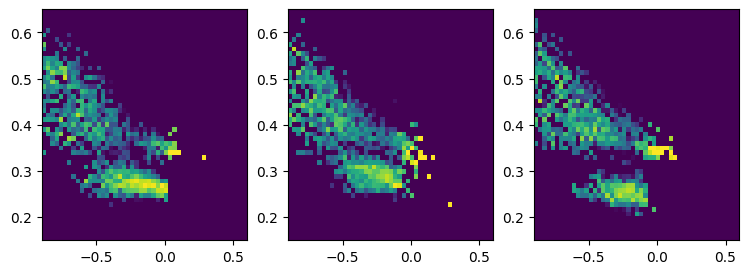

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Rmin = 5
# Rmax = 11
# zmax = 3
Rmin = 4
Rmax = 16
zmin = 0
zmax = 3

print(plot_map(fig, axs[0], gals['MW7_GSE4_sf02_l5'], Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax).get_clim())
print(plot_map(fig, axs[1], gals['MW7_GSE4_sf03_l5'], Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax).get_clim())
print(plot_map(fig, axs[2], gals['MW7_GSE4_sf04_l5'], Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax).get_clim())

NameError: name 'gals' is not defined

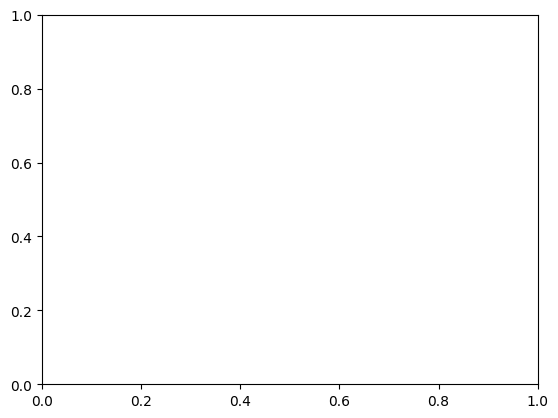

In [5]:
def get_logFeH_cut(gal):
    logFeH_mid = -0.25
    dlogFeH = 0.1
    
    tform_min =0.
    tform_max = 10
    
    R = np.linalg.norm(gal.sn.part4.rotpos[:,:2], axis=1)
    z = gal.sn.part4.rotpos[:,2]
    key_R = np.logical_and(R < 16, R > 4)
    key = np.logical_and(key_R, np.abs(z) < 3)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    key = np.logical_and(key, tform > tform_min)
    key = np.logical_and(key, tform < tform_max)
    
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    key = np.logical_and(key, np.abs(logFeH - logFeH_mid) < dlogFeH/2.)
    return key, logMgFe

fig, ax = plt.subplots(1, 1)
# bins = np.linspace(0.15, 0.5, 50)
bins=50

for k in gals.keys():
    # if '03' not in k:
        # conit
    gal = gals[k]
    key, logMgFe = get_logFeH_cut(gals[k])
    ax.hist(10.**logMgFe[key], density=True, bins=bins, histtype='step', label=k);

ax.legend(frameon=False)

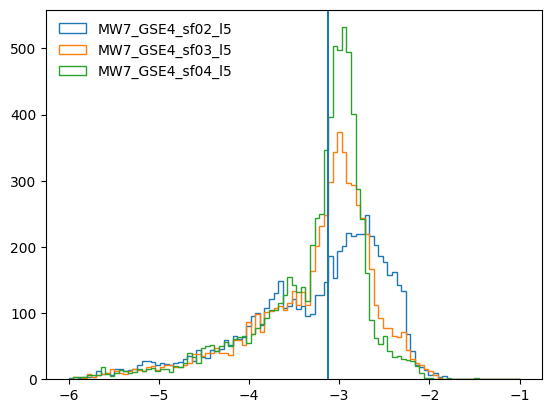

In [78]:
for k in gals.keys():
    gal = gals[k]
    sn, sub = gal.sn, gal.sub
    
    r0 = np.linalg.norm(sn.part0.pos.value - sub.SubhaloPos[0], axis=1)
    rho0 = sn.part0.rho.value
    bins = np.linspace(-6, -1, 100)
    plt.hist(np.log10(rho0[r0 < 10]), bins=bins, histtype='step', label=k)

plt.axvline(np.log10(0.000754654))
plt.legend(frameon=False)

In [11]:
sfr['MW7_GSE4_sf03_l5'][sfr['MW7_GSE4_sf03_l5'][:,2] > 0, 0]

array([ 0.07446289,  0.07568359,  0.0769043 , ...,  9.999771  ,
        9.999847  , 10.        ])

In [18]:
sfr['MW7_GSE4_sf03_l5'][500]

array([0.241394  , 0.        , 0.937758  , 0.        , 0.        ,
       0.00845223])